In [1]:
!pip -qq install super-gradients==3.6.0 pytorch-quantization==2.1.2 --extra-index-url https://pypi.ngc.nvidia.com

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 8.5 MB/s e

In [2]:
from super_gradients import Trainer
import pprint

experiment_name = "cifar100_ptq_qat_classification"

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name=experiment_name, ckpt_root_dir=CHECKPOINT_DIR)

[2024-03-13 01:57:30] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-03-13 01:57:39] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
W0313 01:57:39.681090 140065400598528 env_sanity_check.py:95] Failed to verify installed packages: boto3 required but not found
[2024-03-13 01:57:39] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
W0313 01:57:39.683097 140065400598528 env_sanity_check.py:95] Failed to verify installed packages: deprecated required but not found
[2024-03-13 01:57:39] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
W0313 01:57:39.685433 140065400598528 env_sanity_check.py:95] Failed to verify installed packages: coverage required but not found
I0313 01:57:39.687216 140065400598528 env_sanity_check.py:112] sphinx==5.0.2 does not satisfy requirement sphinx~=4.0.2
[2024-03-13 01:57:39] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but

In [3]:
from super_gradients.training import dataloaders
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define data augmentation transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create train and validation datasets
train_dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR100(root="./data", train=False, download=True, transform=valid_transform)

# Create train and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2, persistent_workers=True)


100%|██████████| 169001437/169001437 [00:02<00:00, 77989967.24it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from matplotlib import pyplot as plt

def show(images, labels, classes, rows=6, columns=5):
  fig = plt.figure(figsize=(10, 10))

  for i in range(1, columns * rows + 1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i-1].permute(1, 2, 0).clamp(0, 1))
      plt.xticks([])
      plt.yticks([])
      plt.title(f"{classes[labels[i-1]]}")

torch.Size([64, 3, 224, 224]) torch.Size([64])


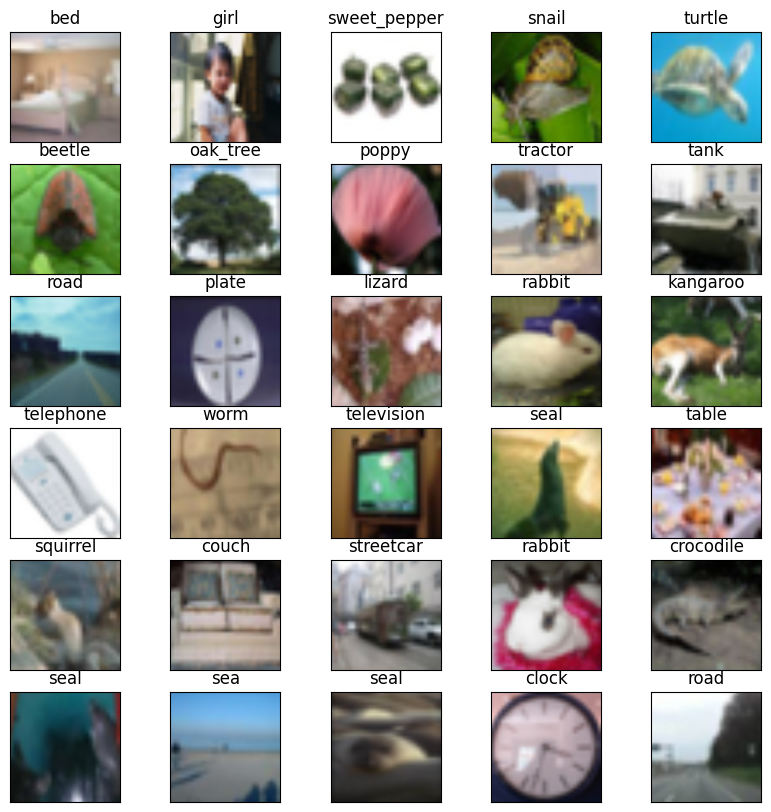

In [5]:
vis_images_train, vis_labels_train = next(iter(train_dataloader))
show(vis_images_train, vis_labels_train, classes=train_dataloader.dataset.classes)

print(vis_images_train.shape, vis_labels_train.shape)

In [6]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model_type = 'mobilenet'

if model_type == 'resnet':
  model = models.get(model_name=Models.RESNET50, num_classes=100, pretrained_weights="imagenet")
elif model_type == 'efficientnet':
  model = models.get(model_name=Models.EFFICIENTNET_B0, num_classes=100, pretrained_weights="imagenet")
elif model_type == 'mobilenet':
  model = models.get(model_name=Models.MOBILENET_V3_SMALL, num_classes=100, pretrained_weights="imagenet")
else:
  raise ValueError(f"Unknown model type: {model_type}")

Downloading: "https://sghub.deci.ai/models/mobilenet_v3_small_imagenet.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small_imagenet.pth
 83%|████████▎ | 24.4M/29.3M [00:01<00:00, 15.9MB/s]

In [7]:
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams

# you can see more recipes in super_gradients/recipes
training_params =  training_hyperparams.get("training_hyperparams/imagenet_mobilenetv3_train_params")

/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/imagenet_mobilenetv3_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [8]:
pprint.pprint("Training parameters")
pprint.pprint(training_params)

In [9]:
training_params["initial_lr"] = 0.1
training_params["max_epochs"] = 10
training_params["lr_updates"] = [10, 25, 45]
training_params["lr_warmup_epochs"] = 5
training_params["warmup_initial_lr"] = 0.01
training_params["save_ckpt_epoch_list"] = [1, 5, 10]

In [11]:
trainer.train(model=model,
              training_params=training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2024-03-13 02:15:53] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2024-03-13 02:15:53] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240313_021553_105815`
[2024-03-13 02:15:53] INFO - sg_trainer.py - Checkpoints directory: checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815
[2024-03-13 02:15:53] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15}
[2024-03-13 02:15:53] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            50000      (len(train_set))
    - Batch size per GPU:           64         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             64         (num_gpus * batch_size)
    - Effective Batch size:        

The console stream is now moved to checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/console_Mar13_02_15_53.txt


Validating: 100%|██████████| 157/157 [00:08<00:00, 19.59it/s]
[2024-03-13 02:17:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:17:17] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8109999895095825
Train epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

SUMMARY OF EPOCH 0
├── Train
│   ├── Crossentropyloss = 0.9488
│   ├── Accuracy = 0.9819
│   └── Top5 = 0.9997
└── Validation
    ├── Crossentropyloss = 1.3917
    ├── Accuracy = 0.811
    └── Top5 = 0.9637



Validating epoch 1: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Crossentropyloss = 0.9578
│   │   ├── Epoch N-1      = 0.9488 (↗ 0.009)
│   │   └── Best until now = 0.9488 (↗ 0.009)
│   ├── Accuracy = 0.9785
│   │   ├── Epoch N-1      = 0.9819 (↘ -0.0034)
│   │   └── Best until now = 0.9819 (↘ -0.0034)
│   └── Top5 = 0.9996
│       ├── Epoch N-1      = 0.9997 (↘ -0.0001)
│       └── Best until now = 0.9997 (↘ -0.0001)
└── Validation
    ├── Crossentropyloss = 1.4036
    │   ├── Epoch N-1      = 1.3917 (↗ 0.0119)
    │   └── Best until now = 1.3917 (↗ 0.0119)
    ├── Accuracy = 0.8073
    │   ├── Epoch N-1      = 0.811  (↘ -0.0037)
    │   └── Best until now = 0.811  (↘ -0.0037)
    └── Top5 = 0.9629
        ├── Epoch N-1      = 0.9637 (↘ -0.0008)
        └── Best until now = 0.9637 (↘ -0.0008)



Validating epoch 2: 100%|██████████| 157/157 [00:08<00:00, 18.95it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Crossentropyloss = 0.9708
│   │   ├── Epoch N-1      = 0.9578 (↗ 0.013)
│   │   └── Best until now = 0.9488 (↗ 0.022)
│   ├── Accuracy = 0.9729
│   │   ├── Epoch N-1      = 0.9785 (↘ -0.0056)
│   │   └── Best until now = 0.9819 (↘ -0.009)
│   └── Top5 = 0.9995
│       ├── Epoch N-1      = 0.9996 (↘ -0.0001)
│       └── Best until now = 0.9997 (↘ -0.0002)
└── Validation
    ├── Crossentropyloss = 1.4099
    │   ├── Epoch N-1      = 1.4036 (↗ 0.0063)
    │   └── Best until now = 1.3917 (↗ 0.0182)
    ├── Accuracy = 0.8055
    │   ├── Epoch N-1      = 0.8073 (↘ -0.0018)
    │   └── Best until now = 0.811  (↘ -0.0055)
    └── Top5 = 0.9613
        ├── Epoch N-1      = 0.9629 (↘ -0.0016)
        └── Best until now = 0.9637 (↘ -0.0024)



Validating epoch 3: 100%|██████████| 157/157 [00:08<00:00, 19.30it/s]
[2024-03-13 02:21:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:21:35] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8119000196456909
Train epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

SUMMARY OF EPOCH 3
├── Train
│   ├── Crossentropyloss = 1.0199
│   │   ├── Epoch N-1      = 0.9708 (↗ 0.0491)
│   │   └── Best until now = 0.9488 (↗ 0.0711)
│   ├── Accuracy = 0.9544
│   │   ├── Epoch N-1      = 0.9729 (↘ -0.0185)
│   │   └── Best until now = 0.9819 (↘ -0.0275)
│   └── Top5 = 0.999
│       ├── Epoch N-1      = 0.9995 (↘ -0.0006)
│       └── Best until now = 0.9997 (↘ -0.0007)
└── Validation
    ├── Crossentropyloss = 1.4038
    │   ├── Epoch N-1      = 1.4099 (↘ -0.0061)
    │   └── Best until now = 1.3917 (↗ 0.0121)
    ├── Accuracy = 0.8119
    │   ├── Epoch N-1      = 0.8055 (↗ 0.0064)
    │   └── Best until now = 0.811  (↗ 0.0009)
    └── Top5 = 0.9606
        ├── Epoch N-1      = 0.9613 (↘ -0.0007)
        └── Best until now = 0.9637 (↘ -0.0031)



Validating epoch 4: 100%|██████████| 157/157 [00:08<00:00, 19.27it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Crossentropyloss = 1.1839
│   │   ├── Epoch N-1      = 1.0199 (↗ 0.1639)
│   │   └── Best until now = 0.9488 (↗ 0.235)
│   ├── Accuracy = 0.8908
│   │   ├── Epoch N-1      = 0.9544 (↘ -0.0635)
│   │   └── Best until now = 0.9819 (↘ -0.0911)
│   └── Top5 = 0.9926
│       ├── Epoch N-1      = 0.999  (↘ -0.0064)
│       └── Best until now = 0.9997 (↘ -0.0071)
└── Validation
    ├── Crossentropyloss = 1.396
    │   ├── Epoch N-1      = 1.4038 (↘ -0.0078)
    │   └── Best until now = 1.3917 (↗ 0.0043)
    ├── Accuracy = 0.811
    │   ├── Epoch N-1      = 0.8119 (↘ -0.0009)
    │   └── Best until now = 0.8119 (↘ -0.0009)
    └── Top5 = 0.9629
        ├── Epoch N-1      = 0.9606 (↗ 0.0023)
        └── Best until now = 0.9637 (↘ -0.0008)



Validating epoch 5: 100%|██████████| 157/157 [00:08<00:00, 19.48it/s]
[2024-03-13 02:24:28] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:24:28] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8126999735832214


SUMMARY OF EPOCH 5
├── Train
│   ├── Crossentropyloss = 1.3371
│   │   ├── Epoch N-1      = 1.1839 (↗ 0.1532)
│   │   └── Best until now = 0.9488 (↗ 0.3882)
│   ├── Accuracy = 0.8348
│   │   ├── Epoch N-1      = 0.8908 (↘ -0.0561)
│   │   └── Best until now = 0.9819 (↘ -0.1471)
│   └── Top5 = 0.9826
│       ├── Epoch N-1      = 0.9926 (↘ -0.01)
│       └── Best until now = 0.9997 (↘ -0.0171)
└── Validation
    ├── Crossentropyloss = 1.3951
    │   ├── Epoch N-1      = 1.396  (↘ -0.0009)
    │   └── Best until now = 1.3917 (↗ 0.0034)
    ├── Accuracy = 0.8127
    │   ├── Epoch N-1      = 0.811  (↗ 0.0017)
    │   └── Best until now = 0.8119 (↗ 0.0008)
    └── Top5 = 0.9629
        ├── Epoch N-1      = 0.9629 (= 0.0)
        └── Best until now = 0.9637 (↘ -0.0008)



Validating epoch 6: 100%|██████████| 157/157 [00:08<00:00, 19.40it/s]
[2024-03-13 02:25:55] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:25:55] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.814300000667572


SUMMARY OF EPOCH 6
├── Train
│   ├── Crossentropyloss = 1.1647
│   │   ├── Epoch N-1      = 1.3371 (↘ -0.1723)
│   │   └── Best until now = 0.9488 (↗ 0.2159)
│   ├── Accuracy = 0.8988
│   │   ├── Epoch N-1      = 0.8348 (↗ 0.064)
│   │   └── Best until now = 0.9819 (↘ -0.0831)
│   └── Top5 = 0.9942
│       ├── Epoch N-1      = 0.9826 (↗ 0.0116)
│       └── Best until now = 0.9997 (↘ -0.0055)
└── Validation
    ├── Crossentropyloss = 1.3935
    │   ├── Epoch N-1      = 1.3951 (↘ -0.0016)
    │   └── Best until now = 1.3917 (↗ 0.0018)
    ├── Accuracy = 0.8143
    │   ├── Epoch N-1      = 0.8127 (↗ 0.0016)
    │   └── Best until now = 0.8127 (↗ 0.0016)
    └── Top5 = 0.9639
        ├── Epoch N-1      = 0.9629 (↗ 0.001)
        └── Best until now = 0.9637 (↗ 0.0002)



Validating epoch 7: 100%|██████████| 157/157 [00:08<00:00, 19.44it/s]
[2024-03-13 02:27:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:27:21] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8159000277519226


SUMMARY OF EPOCH 7
├── Train
│   ├── Crossentropyloss = 0.9842
│   │   ├── Epoch N-1      = 1.1647 (↘ -0.1805)
│   │   └── Best until now = 0.9488 (↗ 0.0354)
│   ├── Accuracy = 0.9673
│   │   ├── Epoch N-1      = 0.8988 (↗ 0.0685)
│   │   └── Best until now = 0.9819 (↘ -0.0146)
│   └── Top5 = 0.9996
│       ├── Epoch N-1      = 0.9942 (↗ 0.0053)
│       └── Best until now = 0.9997 (↘ -0.0002)
└── Validation
    ├── Crossentropyloss = 1.3903
    │   ├── Epoch N-1      = 1.3935 (↘ -0.0031)
    │   └── Best until now = 1.3917 (↘ -0.0013)
    ├── Accuracy = 0.8159
    │   ├── Epoch N-1      = 0.8143 (↗ 0.0016)
    │   └── Best until now = 0.8143 (↗ 0.0016)
    └── Top5 = 0.9646
        ├── Epoch N-1      = 0.9639 (↗ 0.0007)
        └── Best until now = 0.9639 (↗ 0.0007)



Validating epoch 8: 100%|██████████| 157/157 [00:08<00:00, 19.32it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Crossentropyloss = 0.9036
│   │   ├── Epoch N-1      = 0.9842 (↘ -0.0806)
│   │   └── Best until now = 0.9488 (↘ -0.0452)
│   ├── Accuracy = 0.9925
│   │   ├── Epoch N-1      = 0.9673 (↗ 0.0251)
│   │   └── Best until now = 0.9819 (↗ 0.0106)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 0.9996 (↗ 0.0004)
│       └── Best until now = 0.9997 (↗ 0.0002)
└── Validation
    ├── Crossentropyloss = 1.387
    │   ├── Epoch N-1      = 1.3903 (↘ -0.0034)
    │   └── Best until now = 1.3903 (↘ -0.0034)
    ├── Accuracy = 0.8163
    │   ├── Epoch N-1      = 0.8159 (↗ 0.0004)
    │   └── Best until now = 0.8159 (↗ 0.0004)
    └── Top5 = 0.9651
        ├── Epoch N-1      = 0.9646 (↗ 0.0005)
        └── Best until now = 0.9646 (↗ 0.0005)



[2024-03-13 02:28:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:28:48] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8162999749183655
Validating epoch 9: 100%|██████████| 157/157 [00:08<00:00, 19.39it/s]
[2024-03-13 02:30:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth
[2024-03-13 02:30:14] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8163999915122986


SUMMARY OF EPOCH 9
├── Train
│   ├── Crossentropyloss = 0.8832
│   │   ├── Epoch N-1      = 0.9036 (↘ -0.0204)
│   │   └── Best until now = 0.9036 (↘ -0.0204)
│   ├── Accuracy = 0.9963
│   │   ├── Epoch N-1      = 0.9925 (↗ 0.0038)
│   │   └── Best until now = 0.9925 (↗ 0.0038)
│   └── Top5 = 1.0
│       ├── Epoch N-1      = 1.0    (↗ 0.0)
│       └── Best until now = 1.0    (↗ 0.0)
└── Validation
    ├── Crossentropyloss = 1.3841
    │   ├── Epoch N-1      = 1.387  (↘ -0.0029)
    │   └── Best until now = 1.387  (↘ -0.0029)
    ├── Accuracy = 0.8164
    │   ├── Epoch N-1      = 0.8163 (↗ 0.0001)
    │   └── Best until now = 0.8163 (↗ 0.0001)
    └── Top5 = 0.9648
        ├── Epoch N-1      = 0.9651 (↘ -0.0003)
        └── Best until now = 0.9651 (↘ -0.0003)



[2024-03-13 02:30:15] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10:  97%|█████████▋| 152/157 [00:07<00:00, 18.16it/s]

In [16]:
import copy
import os
import sys
import torch
from torch import nn
from super_gradients.training.utils.quantization.calibrator import QuantizationCalibrator
from super_gradients.training.utils.quantization.export import export_quantized_module_to_onnx
from super_gradients.training.utils.quantization.selective_quantization_utils import SelectiveQuantizer
from super_gradients.modules.repvgg_block import fuse_repvgg_blocks_residual_branches

def load_checkpoint(model, ckpt_file):
  checkpoint = torch.load(ckpt_file, map_location="cpu")
  ckpt_key = "ema_net" if "ema_net" in checkpoint else "net"
  state_dict = checkpoint[ckpt_key]
  model.load_state_dict(state_dict)

def validate_model(model, dataloader, training_hyperparams):
  trainer = Trainer(experiment_name=experiment_name, ckpt_root_dir=CHECKPOINT_DIR)

  valid_metrics_dict = trainer.test(model=model, test_loader=dataloader, test_metrics_list=training_hyperparams.get("valid_metrics_list"))

  results = ["Validate Results"]
  results += [f"\t- {metric:4}: {value:.3f}" for metric, value in valid_metrics_dict.items()]

  res_string = "\r\n".join(results)

  print(res_string, file=sys.stderr)

  return valid_metrics_dict

print(os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
load_checkpoint(model, os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
validate_model(model, valid_dataloader, training_params)

checkpoints/cifar100_ptq_qat_classification/RUN_20240313_021553_105815/ckpt_best.pth


Testing:  97%|█████████▋| 153/157 [00:07<00:00, 19.55it/s]

{'Accuracy': 0.8163999915122986, 'Top5': 0.9648000001907349}

POST TRAINING QUANTIZATION (PTQ)

In [17]:
def quantize_and_calibrate(
    model: nn.Module,
    calibration_dataloader,
    num_calib_batches=16,             # number of batches to use for calibration
    method_w="max",                   # calibrator type for weights, acceptable types are ["max", "histogram"]
    method_i="histogram",             # calibrator type for inputs, acceptable types are ["max", "histogram"]
    calibration_method="percentile",  # calibration method for all "histogram" calibrators, acceptable types are ["percentile", "entropy", mse"], "max" calibrators are not affected
    percentile=99.99,                 # percentile for all histogram calibrators with method "percentile", other calibrators are not affected
    per_channel=True,                 # per-channel quantization of weights, activations stay per-tensor by default
    learn_amax=False,                 # enable learnable amax in all TensorQuantizers using straight-through estimator
    skip_modules=None,                # optional list of module names (strings) to skip from quantization
    verbose=False,                    # if calibrator should be verbose
):
    model.eval()

    q_util = SelectiveQuantizer(
        default_quant_modules_calibrator_weights=method_w,
        default_quant_modules_calibrator_inputs=method_i,
        default_per_channel_quant_weights=per_channel,
        default_learn_amax=learn_amax,
        verbose=verbose
    )

    if skip_modules is not None:
        q_util.register_skip_quantization(layer_names=set(skip_modules))

    calibrator = QuantizationCalibrator(verbose=verbose, torch_hist=True)

    # RepVGG and QARepVGG can be quantized only in the fused form
    fuse_repvgg_blocks_residual_branches(model)
    q_util.quantize_module(model)

    calibrator.calibrate_model(
        model,
        method=calibration_method,
        calib_data_loader=calibration_dataloader,
        num_calib_batches=num_calib_batches,
        percentile=percentile,
    )

    model.train()
    return model


In [22]:
load_checkpoint(model, os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
ptq_model = quantize_and_calibrate(copy.deepcopy(model),
                                    train_dataloader,
                                    num_calib_batches=4,
                                    method_w="max",
                                    method_i="histogram",
                                    calibration_method="mse",
                                    percentile=99.99,
                                    per_channel=True,
                                    learn_amax=False,
                                    skip_modules=None,
                                    verbose=False)

100%|██████████| 4/4 [00:00<00:00,  6.18it/s]


In [23]:
validate_model(ptq_model, valid_dataloader, training_params)

Testing: 100%|██████████| 157/157 [00:18<00:00,  8.64it/s]


{'Accuracy': 0.5770000219345093, 'Top5': 0.8324000239372253}